In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [5]:
import zipfile
with zipfile.ZipFile("/kaggle/input/data-science-bowl-2018/stage1_train.zip", 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working/train/")

In [6]:
train_labels = pd.read_csv("/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip")
train_labels

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3
...,...,...
29456,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,31317 2 31676 5 32035 6 32394 7 32753 8 33112 ...
29457,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,110318 4 110675 13 111034 19 111391 23 111750 ...
29458,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,24841 1 25201 2 25561 2 25921 3 26281 4 26641 ...
29459,ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d...,4061 8 4417 14 4775 21 5134 23 5494 24 5853 26...


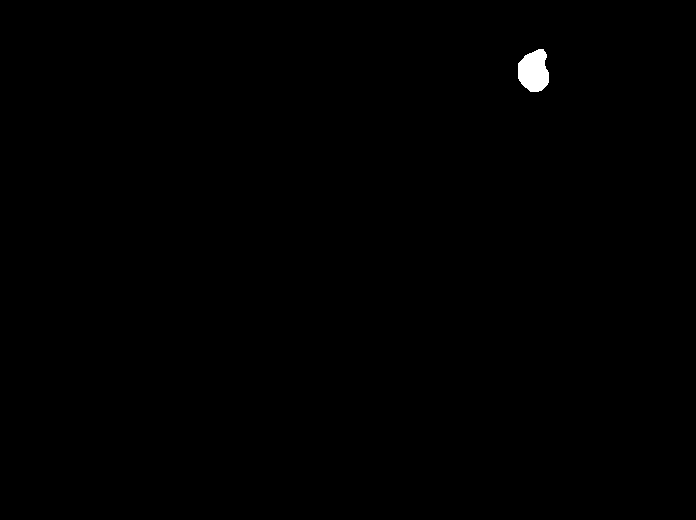

In [7]:
import PIL

PIL.Image.open("/kaggle/working/train/6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622/masks/4f38e00beddd2901eca0fe26ecd93402456e120d4af23625e65a3582cb136c45.png")

## Fusion of masks

In [8]:
from PIL import Image

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img = Image.open(os.path.join(folder, filename)).convert("L")  # Convert to grayscale
            if img is not None:
                images.append(np.array(img))
    return images

def fuse_masks(images):
    if not images:
        raise ValueError("No images to fuse")
        
    # Initialize the final mask as the same size as the first image, with all zeros (background)
    final_mask = np.zeros_like(images[0], dtype=np.uint8)
    
    # Fuse masks by taking the maximum value of each pixel across all images (assuming 0 is background)
    for img in images:
        final_mask = np.maximum(final_mask, img)  # Keep the maximum value at each pixel position
        
    return final_mask

def save_image(image_array, output_path):
    # Convert NumPy array back to image
    img = Image.fromarray(image_array)
    img.save(output_path)
    
def fuse_and_save(folder_path, output_path):
    masks = load_images_from_folder(folder_path)
    fused_mask = fuse_masks(masks)
    save_image(fused_mask, output_path)

In [9]:
from tqdm import tqdm

# Define the main directory path
main_dir = "/kaggle/working/train/"

# Create an empty list to store the data for the DataFrame
data = []

# Loop through each patient's folder
for patient_folder in tqdm(os.listdir(main_dir)):
    patient_path = os.path.join(main_dir, patient_folder)
    
    # Ensure it's a directory
    if os.path.isdir(patient_path):
        masks_folder = os.path.join(patient_path, "masks")
        image_folder = os.path.join(patient_path, "images")
        
        # Get all mask files and image files
        if os.path.exists(masks_folder) and os.path.exists(image_folder):
            # Assume the image file is the first one in the image folder
            image_files = [f for f in os.listdir(image_folder) if f.endswith(".png")]
            mask_files = [f for f in os.listdir(masks_folder) if f.endswith(".png")]

            if image_files and mask_files:
                image_path = os.path.join(image_folder, f"{patient_folder}.png")
                image_shape = Image.open(image_path).size
                fused_mask_path = os.path.join(patient_path, f"{patient_folder}_fused_mask.png")
                fuse_and_save(masks_folder, fused_mask_path)
                
                # Append the paths to the data list
                data.append({
                    'image_path': image_path,
                    'fused_segmentation_path': fused_mask_path,
                    'width': image_shape[0],
                    'height': image_shape[1]
                })

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file (optional)
output_csv_path = "/kaggle/working/annotation_dataframe.csv"
df.drop(columns=["height", "width"]).to_csv(output_csv_path, index=False)

print(f"Annotation DataFrame created and saved to {output_csv_path}")
df

100%|██████████| 670/670 [00:30<00:00, 21.93it/s]

Annotation DataFrame created and saved to /kaggle/working/annotation_dataframe.csv


,image_path,fused_segmentation_path,width,height
0,/kaggle/working/train/d2815f2f616d92be35c7e8dc...,/kaggle/working/train/d2815f2f616d92be35c7e8dc...,256,256
1,/kaggle/working/train/b6edad733399c83c8eb7a59c...,/kaggle/working/train/b6edad733399c83c8eb7a59c...,360,360
2,/kaggle/working/train/e81c758e1ca177b0942ecad6...,/kaggle/working/train/e81c758e1ca177b0942ecad6...,256,256
3,/kaggle/working/train/aa83f5b4fca02ae43a6b9456...,/kaggle/working/train/aa83f5b4fca02ae43a6b9456...,256,256
4,/kaggle/working/train/3d0ca3498d97edebd28dbc70...,/kaggle/working/train/3d0ca3498d97edebd28dbc70...,256,256
...,...,...,...,...
665,/kaggle/working/train/5d2c98fd6fda3c7d739461c3...,/kaggle/working/train/5d2c98fd6fda3c7d739461c3...,256,256
666,/kaggle/working/train/01d44a26f6680c42ba94c9bc...,/kaggle/working/train/01d44a26f6680c42ba94c9bc...,320,256
667,/kaggle/working/train/449f41710769584b5e4eca8e...,/kaggle/working/train/449f41710769584b5e4eca8e...,696,520
668,/kaggle/working/train/3ca8181367fc1258a418f7bf...,/kaggle/working/train/3ca8181367fc1258a418f7bf...,360,360


In [69]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image


class ImageDataset(Dataset):
    def __init__(self, annotation_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file)
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = Image.open(self.img_labels.iloc[idx, 0]).convert("L")
        label = Image.open(self.img_labels.iloc[idx, 1]).convert("L")
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        image = torch.tensor(image / 255, dtype=torch.float32)
        label = torch.tensor(label / 255, dtype=torch.float32)
        return image, label

In [70]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

resize_transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.PILToTensor()
])

dataset = ImageDataset("/kaggle/working/annotation_dataframe.csv", transform=resize_transform, target_transform=resize_transform)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3)
val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

/tmp/ipykernel_30/1345958676.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image / 255, dtype=torch.float32)
/tmp/ipykernel_30/1345958676.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label / 255, dtype=torch.float32)


In [ ]:
!pip install monai
!pip install segmentation-models-pytorch

In [77]:
import monai
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = monai.networks.nets.UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=(32, 64, 128), strides=(2, 2))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = StepLR(optimizer, 20)
criterion = smp.losses.DiceLoss(mode='binary')
num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.
    
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        
        train_loss = criterion(outputs, labels)
        
        train_loss.backward()
        optimizer.step()
    
        running_loss += train_loss.item()
    
    avg_train_loss = running_loss / len(train_dataloader)
    
    # Validation
    model.eval()
    val_running_loss = 0.
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            
            val_loss = criterion(outputs, labels)

            val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(val_dataloader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
    scheduler.step(avg_val_loss)

Epoch [10/150], Loss: 0.7122491002082825, Val Loss: 0.6945833265781403
Epoch [20/150], Loss: 0.7133600786328316, Val Loss: 0.6902025043964386
Epoch [30/150], Loss: 0.7049125283956528, Val Loss: 0.6858710050582886
Epoch [40/150], Loss: 0.7113022804260254, Val Loss: 0.6955064237117767
Epoch [50/150], Loss: 0.7059641480445862, Val Loss: 0.6925513446331024
Epoch [60/150], Loss: 0.7063194513320923, Val Loss: 0.6868863701820374
Epoch [70/150], Loss: 0.7088895589113235, Val Loss: 0.6962381303310394
Epoch [80/150], Loss: 0.7082246616482735, Val Loss: 0.6968750357627869
Epoch [90/150], Loss: 0.704021580517292, Val Loss: 0.6836594045162201
Epoch [100/150], Loss: 0.7047558501362801, Val Loss: 0.6905461549758911
Epoch [110/150], Loss: 0.7059894651174545, Val Loss: 0.6978133916854858
Epoch [120/150], Loss: 0.7056246101856232, Val Loss: 0.6933782398700714
Epoch [130/150], Loss: 0.7050684466958046, Val Loss: 0.6870404183864594
Epoch [140/150], Loss: 0.7064777240157127, Val Loss: 0.6904056072235107
Ep

In [87]:
def dice_coefficient(preds, labels, smooth=1e-6):
    # Flatten the tensors
    preds = preds.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    
    intersection = (preds * labels).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + labels.sum() + smooth)
    
    return dice.item()

In [88]:
import torchmetrics
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy

iou_metric = BinaryJaccardIndex().to(device)
accuracy_metric = BinaryAccuracy().to(device)

dice_scores = []
iou_scores = []
pixel_accuracies = []

model.eval()

with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        
        preds = (outputs > 0.5).float()
        
        dice = dice_coefficient(preds, labels)
        dice_scores.append(dice)
        
        iou = iou_metric(preds, labels.long())
        iou_scores.append(iou.item())
        
        accuracy = accuracy_metric(preds, labels.long())
        pixel_accuracies.append(accuracy.item())

avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)
avg_pixel_accuracy = np.mean(pixel_accuracies)

print(f"Test Dice Coefficient: {avg_dice:.4f}")
print(f"Test IoU: {avg_iou:.4f}")
print(f"Test Pixel Accuracy: {avg_pixel_accuracy:.4f}")

Test Dice Coefficient: 0.8954
Test IoU: 0.7465
Test Pixel Accuracy: 0.9570


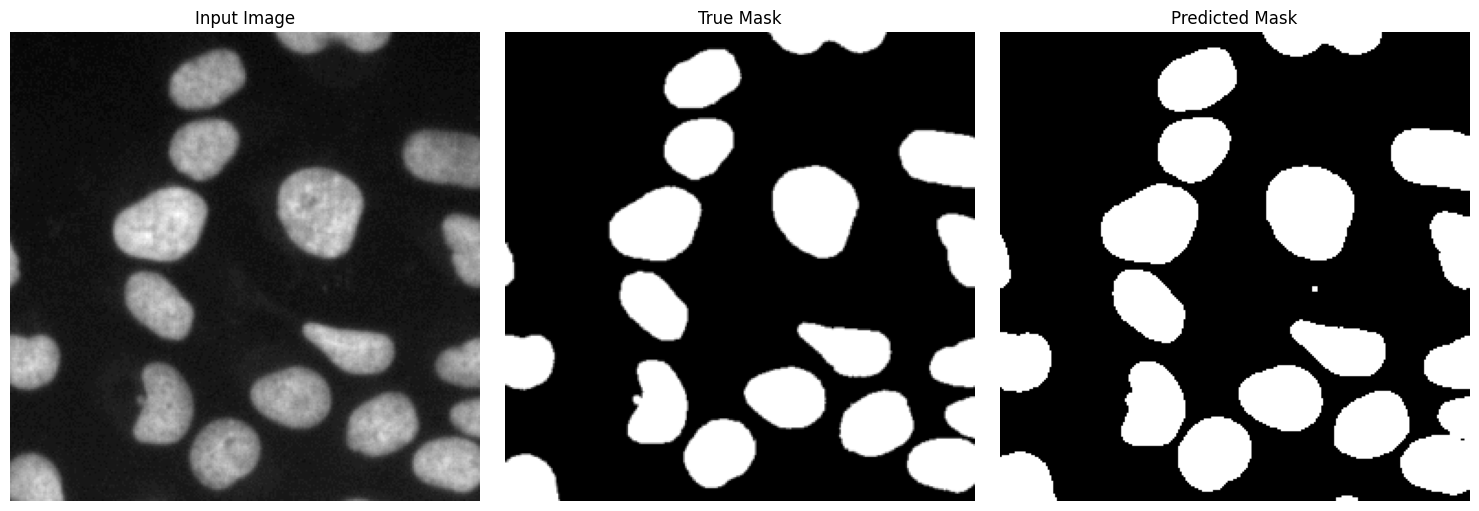

In [89]:
import matplotlib.pyplot as plt

model.eval()

random_idx = random.randint(0, len(test_dataloader) - 1)
batch = next(iter(test_dataloader))

inputs, labels = batch
inputs, labels = inputs.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

preds = (outputs > 0.5).float()

idx = random.randint(0, inputs.size(0) - 1)
input_image = inputs[idx].cpu().squeeze().numpy()  # Assuming single-channel image
true_mask = labels[idx].cpu().squeeze().numpy()    # True mask
predicted_mask = preds[idx].cpu().squeeze().numpy()  # Predicted mask

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(input_image, cmap='gray')
ax[0].set_title('Input Image')

ax[1].imshow(true_mask, cmap='gray')
ax[1].set_title('True Mask')

ax[2].imshow(predicted_mask, cmap='gray')
ax[2].set_title('Predicted Mask')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()
